In [1]:
#All Required Libraries
import os
import time
import math
import csv
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint #Otherwise only "odeint_adjoint"

In [3]:
#Configuration
method = 'rk4' #RK-45 (rk4)
data_size = 900 #300 every 10 seconds
batch_time = 10
batch_size = 20
niters = 1500
test_freq = 10
viz = True
gpu = 0
#device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [4]:
#Define ODE System
#torch.set_default_dtype(torch.float64)
omega0 = torch.tensor(2*60*np.pi)
delta1star = 0.543714502378423
omega1star = 0
delta2star = -0.657898240642551
omega2star = 0
delta3star = 0.038658833144357
omega3star = 0
v1star = torch.tensor(2.342701509994243)
v2star = torch.tensor(2.417838912110000)
v3star = torch.tensor(2.050366207960745)

x0 = torch.tensor([[delta1star + np.pi/6], [omega1star], [delta2star], [omega2star], [delta3star], [omega3star]]).to(device)
t = torch.arange(0.,30., 1/30).to(device) #1/30

M1 = torch.tensor(100)
D1 = torch.tensor(10)
#X1 = torch.tensor(0.963)
M2 = torch.tensor(18)
D2 = torch.tensor(10)
#X2 = torch.tensor(0.911)
M3 = torch.tensor(12)
D3 = torch.tensor(10)
#X3 = torch.tensor(0.667)

G12 = torch.tensor(5.956920547916505e-04)
B12 = torch.tensor(-0.310894430043027)
G13 = torch.tensor(-0.007639071017719)
B13 = torch.tensor(-0.372984139080232)
G23 = torch.tensor(-0.004693638897659)
B23 = torch.tensor(-0.429158911598529)

Pmech1star = torch.tensor(2.478317367015364)
Pmech2star = torch.tensor(-3.023956371876458)
Pmech3star = torch.tensor(0.448153267946861)

#Pmech1star = torch.tensor(-v1star*v2star*B12*np.sin(delta1star - delta2star) + v1star*v2star*G12*np.cos(delta1star-delta2star) - v1star*v3star*B13*np.sin(delta1star - delta3star) + v1star*v3star*G13*np.cos(delta1star-delta3star))
#Pmech2star = torch.tensor(-v1star*v2star*B12*np.sin(delta2star - delta1star) + v1star*v2star*G12*np.cos(delta2star-delta1star) - v2star*v3star*B23*np.sin(delta2star - delta3star) + v2star*v3star*G23*np.cos(delta2star-delta3star))
#Pmech3star = torch.tensor(-v1star*v3star*B13*np.sin(delta3star - delta1star) + v1star*v3star*G13*np.cos(delta3star-delta1star) - v2star*v3star*B23*np.sin(delta3star - delta2star) + v2star*v3star*G23*np.cos(delta3star-delta2star))

class Real(nn.Module):
    def forward(self,t,x):
        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[1] = (-D1*x[1]/omega0 + v1star*v2star*B12*torch.sin(x[0]-x[2]) - v1star*v2star*G12*torch.cos(x[0]-x[2]) + v1star*v3star*B13*torch.sin(x[0]-x[4]) - v1star*v3star*G13*torch.cos(x[0]-x[4]) + Pmech1star)*omega0/M1
        dxdt[2] = x[3]
        dxdt[3] = (-D2*x[3]/omega0 + v1star*v2star*B12*torch.sin(x[2]-x[0]) - v1star*v2star*G12*torch.cos(x[2]-x[0]) + v2star*v3star*B23*torch.sin(x[2]-x[4]) - v2star*v3star*G23*torch.cos(x[2]-x[4]) + Pmech2star)*omega0/M2
        dxdt[4] = x[5]
        dxdt[5] = (-D3*x[5]/omega0 + v1star*v3star*B13*torch.sin(x[4]-x[0]) - v1star*v3star*G13*torch.cos(x[4]-x[0]) + v2star*v3star*B23*torch.sin(x[4]-x[2]) - v2star*v3star*G23*torch.cos(x[4]-x[2]) + Pmech3star)*omega0/M3
        self.dxdt = dxdt
        return dxdt

real_dynamics = Real()  
  
with torch.no_grad():
    true_x = odeint(real_dynamics, x0, t, method = method)

true_delta1 = true_x[:,0,0]
true_omega1 = true_x[:,1,0] / omega0
true_delta2 = true_x[:,2,0]
true_omega2 = true_x[:,3,0] / omega0
true_delta3 = true_x[:,4,0]
true_omega3 = true_x[:,5,0] / omega0

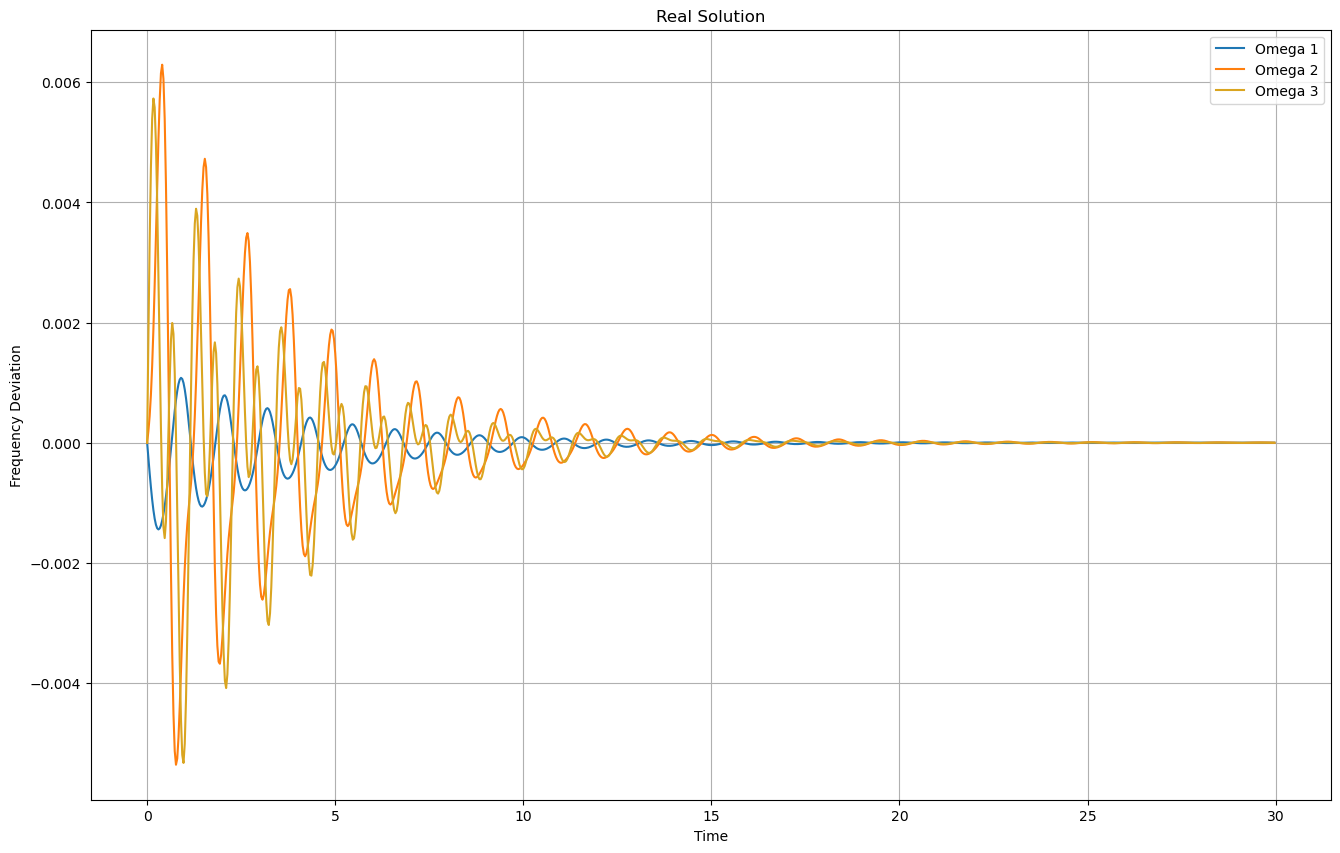

In [5]:
#Plot Correct Data
plt.figure(figsize=(16, 10))
plt.plot(t.cpu().numpy(), true_omega1.cpu().numpy(), label='Omega 1')
plt.plot(t.cpu().numpy(), true_omega2.cpu().numpy(), label='Omega 2')
plt.plot(t.cpu().numpy(), true_omega3.cpu().numpy(), label='Omega 3', color='goldenrod')
plt.xlabel('Time')
plt.ylabel('Frequency Deviation')
plt.title('Real Solution')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
#Define Mini-Batches
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return s.to(device), batch_x0.to(device), batch_t.to(device), batch_x.to(device)

In [17]:
#Visualization

def visualize(true_x, pred_x, t, omega0, viz, save_path):
    if viz:
        # Create a 3x2 subplot layout
        fig, axs = plt.subplots(3, 2, figsize=(16, 10), facecolor='white')

        # Generator 1 - Rotor Angle and Frequency Deviation
        axs[0, 0].set_title('Generator 1 - Rotor Angle')
        axs[0, 0].set_xlabel('Time [s]')
        axs[0, 0].set_ylabel('Rotor Angle')
        axs[0, 0].plot(t.cpu().numpy(), true_x.cpu().numpy()[:,0,0], 'g-', label='True Delta 1')
        axs[0, 0].plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,0,0], 'b--', label='Predicted Delta 1')
        axs[0, 0].legend()

        axs[0, 1].set_title('Generator 1 - Frequency Deviation')
        axs[0, 1].set_xlabel('Time [s]')
        axs[0, 1].set_ylabel('Frequency Deviation')
        axs[0, 1].plot(t.cpu().numpy(), true_x.cpu().numpy()[:,1,0] / omega0, 'g-', label='True Omega 1')
        axs[0, 1].plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,1,0] / omega0, 'b--', label='Predicted Omega 1')
        axs[0, 1].legend()

        # Generator 2 - Rotor Angle and Frequency Deviation
        axs[1, 0].set_title('Generator 2 - Rotor Angle')
        axs[1, 0].set_xlabel('Time [s]')
        axs[1, 0].set_ylabel('Rotor Angle')
        axs[1, 0].plot(t.cpu().numpy(), true_x.cpu().numpy()[:,2,0], 'g-', label='True Delta 2')
        axs[1, 0].plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,2,0], 'b--', label='Predicted Delta 2')
        axs[1, 0].legend()

        axs[1, 1].set_title('Generator 2 - Frequency Deviation')
        axs[1, 1].set_xlabel('Time [s]')
        axs[1, 1].set_ylabel('Frequency Deviation')
        axs[1, 1].plot(t.cpu().numpy(), true_x.cpu().numpy()[:,3,0] / omega0, 'g-', label='True Omega 2')
        axs[1, 1].plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,3,0] / omega0, 'b--', label='Predicted Omega 2')
        axs[1, 1].legend()

        # Generator 3 - Rotor Angle and Frequency Deviation
        axs[2, 0].set_title('Generator 3 - Rotor Angle')
        axs[2, 0].set_xlabel('Time [s]')
        axs[2, 0].set_ylabel('Rotor Angle')
        axs[2, 0].plot(t.cpu().numpy(), true_x.cpu().numpy()[:,4,0], 'g-', label='True Delta 3')
        axs[2, 0].plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,4,0], 'b--', label='Predicted Delta 3')
        axs[2, 0].legend()

        axs[2, 1].set_title('Generator 3 - Frequency Deviation')
        axs[2, 1].set_xlabel('Time [s]')
        axs[2, 1].set_ylabel('Frequency Deviation')
        axs[2, 1].plot(t.cpu().numpy(), true_x.cpu().numpy()[:,5,0] / omega0, 'g-', label='True Omega 3')
        axs[2, 1].plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,5,0] / omega0, 'b--', label='Predicted Omega 3')
        axs[2, 1].legend()

        # Adjust layout
        plt.tight_layout()
        
        # Create directory if it doesn't exist and save the figure
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)

        # Show the plot
        plt.show()

        # Close the plot to free up memory
        plt.close(fig)


In [8]:
#NN to learn the ODE

class NeuralODE(nn.Module):
    def __init__(self, M1, D1, M2, D2, M3, D3, V1, V2, V3, B12, B13, B23, G12, G13, G23, Pmech1, Pmech2, Pmech3):
        super(NeuralODE, self).__init__()
        self.M1 = M1
        self.M2 = nn.Parameter(M2)
        self.M3 = nn.Parameter(M3)
        self.D1 = D1
        self.D2 = nn.Parameter(D2)
        self.D3 = nn.Parameter(D3)
        self.V1 = V1
        self.V2 = V2
        #self.V2 = nn.Parameter(V2)
        self.V3 = V3
        #self.V3 = nn.Parameter(V3)
        self.B12 = B12
        self.B13 = B13
        self.B23 = B23
        self.G12 = G12
        self.G13 = G13
        self.G23 = G23
        self.Pmech1 = Pmech1
        self.Pmech2 = Pmech2
        #self.Pmech2 = nn.Parameter(Pmech2)
        self.Pmech3 = Pmech3
        #self.Pmech3 = nn.Parameter(Pmech3)

    def forward(self, t, y):
        dydt = torch.zeros_like(y)
        dydt[0] = y[1]
        dydt[1] = (-self.D1*y[1]/omega0 + self.V1*self.V2*self.B12*torch.sin(y[0]-y[2]) - self.V1*self.V2*self.G12*torch.cos(y[0]-y[2]) + self.V1*self.V3*self.B13*torch.sin(y[0]-y[4]) - self.V1*self.V3*self.G13*torch.cos(y[0]-y[4]) + self.Pmech1)*omega0/self.M1
        dydt[2] = y[3]
        dydt[3] = (-self.D2*y[3]/omega0 + self.V1*self.V2*self.B12*torch.sin(y[2]-y[0]) - self.V1*self.V2*self.G12*torch.cos(y[2]-y[0]) + self.V2*self.V3*self.B23*torch.sin(y[2]-y[4]) - self.V2*self.V3*self.G23*torch.cos(y[2]-y[4]) + self.Pmech2)*omega0/self.M2
        dydt[4] = y[5]
        dydt[5] = (-self.D3*y[5]/omega0 + self.V1*self.V3*self.B13*torch.sin(y[4]-y[0]) - self.V1*self.V3*self.G13*torch.cos(y[4]-y[0]) + self.V2*self.V3*self.B23*torch.sin(y[4]-y[2]) - self.V2*self.V3*self.G23*torch.cos(y[4]-y[2]) + self.Pmech3)*omega0/self.M3
        self.dydt = dydt
        return dydt

In [ ]:
#DEBUGGING ZONE

Delta = 1.000001 #Porcentual deviation from real value
TargetPercent = 1
M1_G = M1
D1_G = D1
M2_G = Delta*M2
D2_G = Delta*D2
M3_G = Delta*M3
D3_G = Delta*D3
V1_G = v1star
V2_G = v2star
V3_G = v3star
B12_G = B12
B13_G = B13
B23_G = B23
G12_G = G12
G13_G = G13
G23_G = G23
Pmech1_G = Pmech1star
Pmech2_G = Pmech2star
Pmech3_G = Pmech3star

def percent_deviation(current_value, target_value):
     return abs(current_value - target_value) / target_value * 100


print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"M3: {M3.item()}", f"M3_G: {M3_G.item()}")
print(f"D3: {D3.item()}", f"D3_G: {D3_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"V3: {v3star.item()}", f"V3_G: {V3_G.item()}")
print(f"B12: {B12.item()}", f"B12_G: {B12_G.item()}")
print(f"B13: {B13.item()}", f"B13_G: {B13_G.item()}")
print(f"B23: {B23.item()}", f"B23_G: {B23_G.item()}")
print(f"G12: {G12.item()}", f"G12_G: {G12_G.item()}")
print(f"G13: {G13.item()}", f"G13_G: {G13_G.item()}")
print(f"G23: {G23.item()}", f"G23_G: {G23_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")
print(f"Pmech3: {Pmech3star.item()}", f"Pmech3_G: {Pmech3_G.item()}")

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return s.to(device), batch_x0.to(device), batch_t.to(device), batch_x.to(device)

func = NeuralODE(M1_G, D1_G, M2_G, D2_G, M3_G, D3_G, V1_G, V2_G, V3_G, B12_G, B13_G, B23_G, G12_G, G13_G, G23_G, Pmech1_G, Pmech2_G, Pmech3_G).to(device)
optimizer = torch.optim.RMSprop(func.parameters(), lr = 0.001) #RMSprop
end = time.time()
ii = 0

s, batch_x0, batch_t, batch_x = get_batch()

with torch.no_grad():
     for batches in range(0,batch_size):
          pred_x = odeint(func, batch_x0[batches], batch_t, method=method).to(device)
          print(batches+1)
     
#visualize(batch_x, pred_x, func, 0)     

In [ ]:
#DEBUG PRINT
print(batch_x.size())
print(pred_x.size())

print(pred_x[0,0:2,0])
print(batch_x[0,4,0:2,0])
print(pred_x[0,0:2,0] - batch_x[0,4,0:2,0])



M1: 100 M1_G: 100
D1: 10 D1_G: 10
M2: 18 M2_G: 19.80000114440918
D2: 10 D2_G: 11.0
M3: 12 M3_G: 13.200000762939453
D3: 10 D3_G: 11.0
V1: 2.3427014350891113 V1_G: 2.3427014350891113
V2: 2.4178388118743896 V2_G: 2.4178388118743896
V3: 2.050366163253784 V3_G: 2.050366163253784
B12: -0.3108944296836853 B12_G: -0.3108944296836853
B13: -0.3729841411113739 B13_G: -0.3729841411113739
B23: -0.42915892601013184 B23_G: -0.42915892601013184
G12: 0.0005956920795142651 G12_G: 0.0005956920795142651
G13: -0.007639070972800255 G13_G: -0.007639070972800255
G23: -0.004693638999015093 G23_G: -0.004693638999015093
Pmech1: 2.4783172607421875 Pmech1_G: 2.4783172607421875
Pmech2: -3.023956298828125 Pmech2_G: -3.023956298828125
Pmech3: 0.4481532573699951 Pmech3_G: 0.4481532573699951
Initial Parameters:
M2: 19.80000114440918
M3: 13.200000762939453
D2: 11.0
D3: 11.0


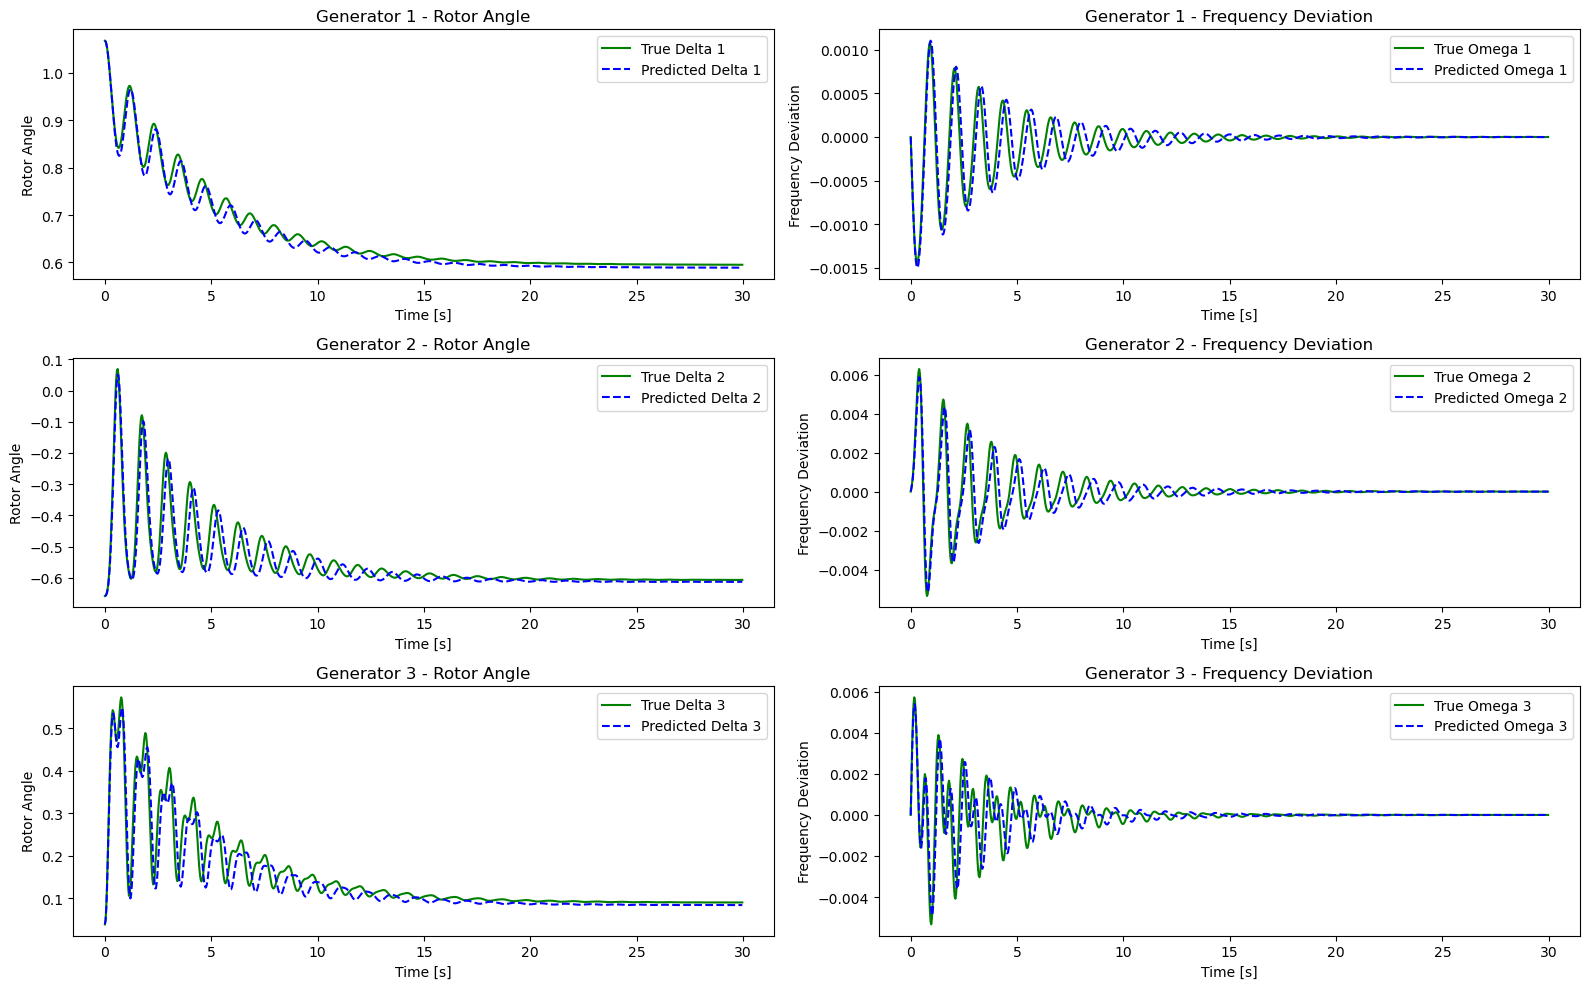


Iteration 0 | Total Loss 0.00121285254135727882
Updated Parameters:
M2: 19.660720825195312
M3: 12.817709922790527
D2: 10.655265808105469
D3: 10.833965301513672


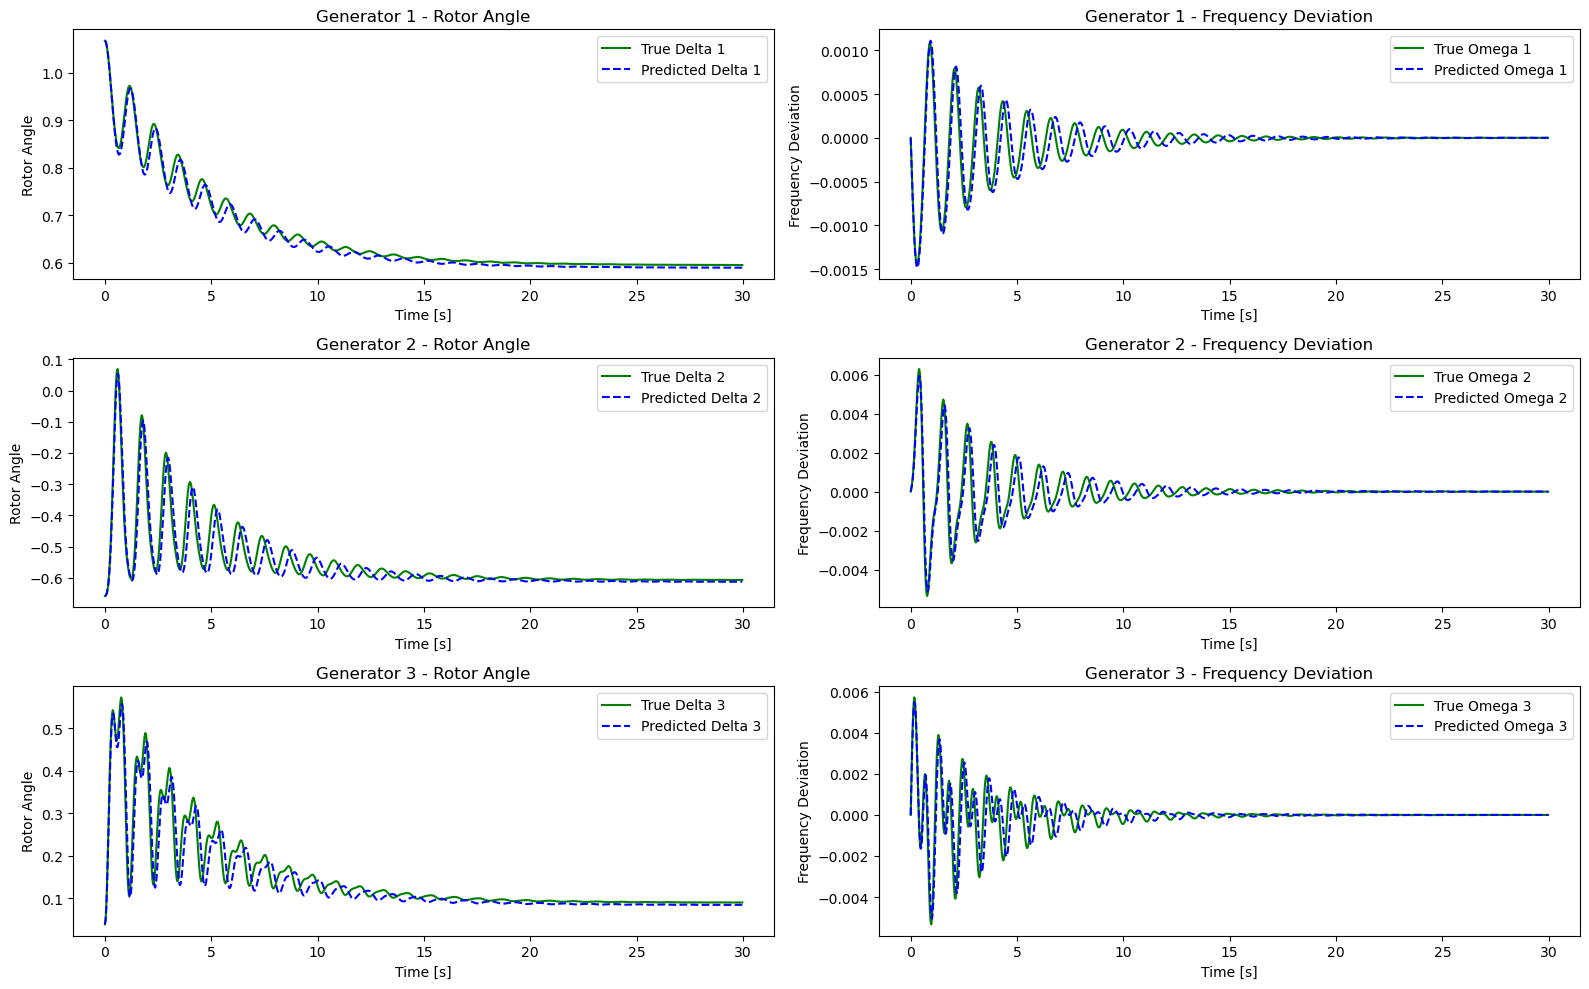

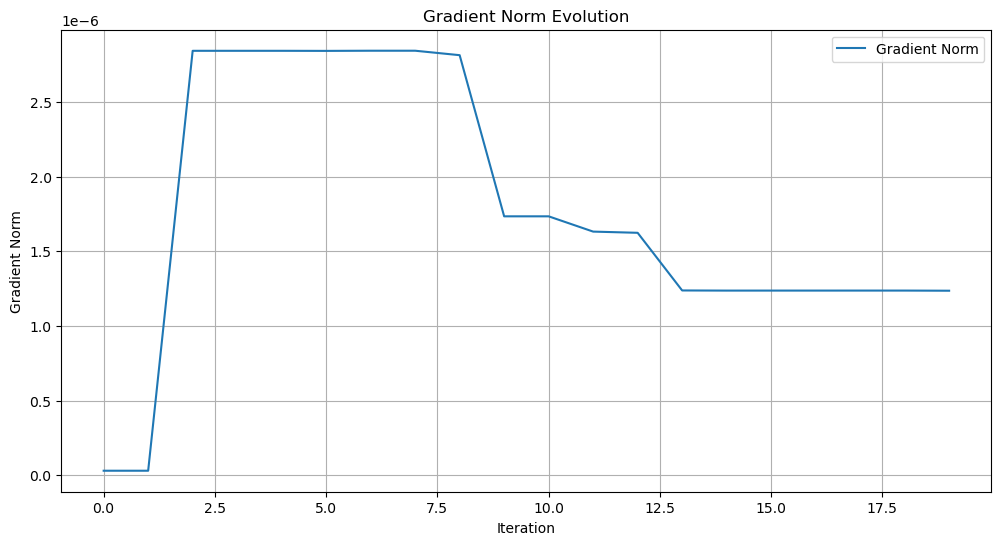


Iteration 10 | Total Loss 0.00029032820020802319
Updated Parameters:
M2: 18.781545639038086
M3: 12.321124076843262
D2: 10.291278839111328
D3: 10.712403297424316


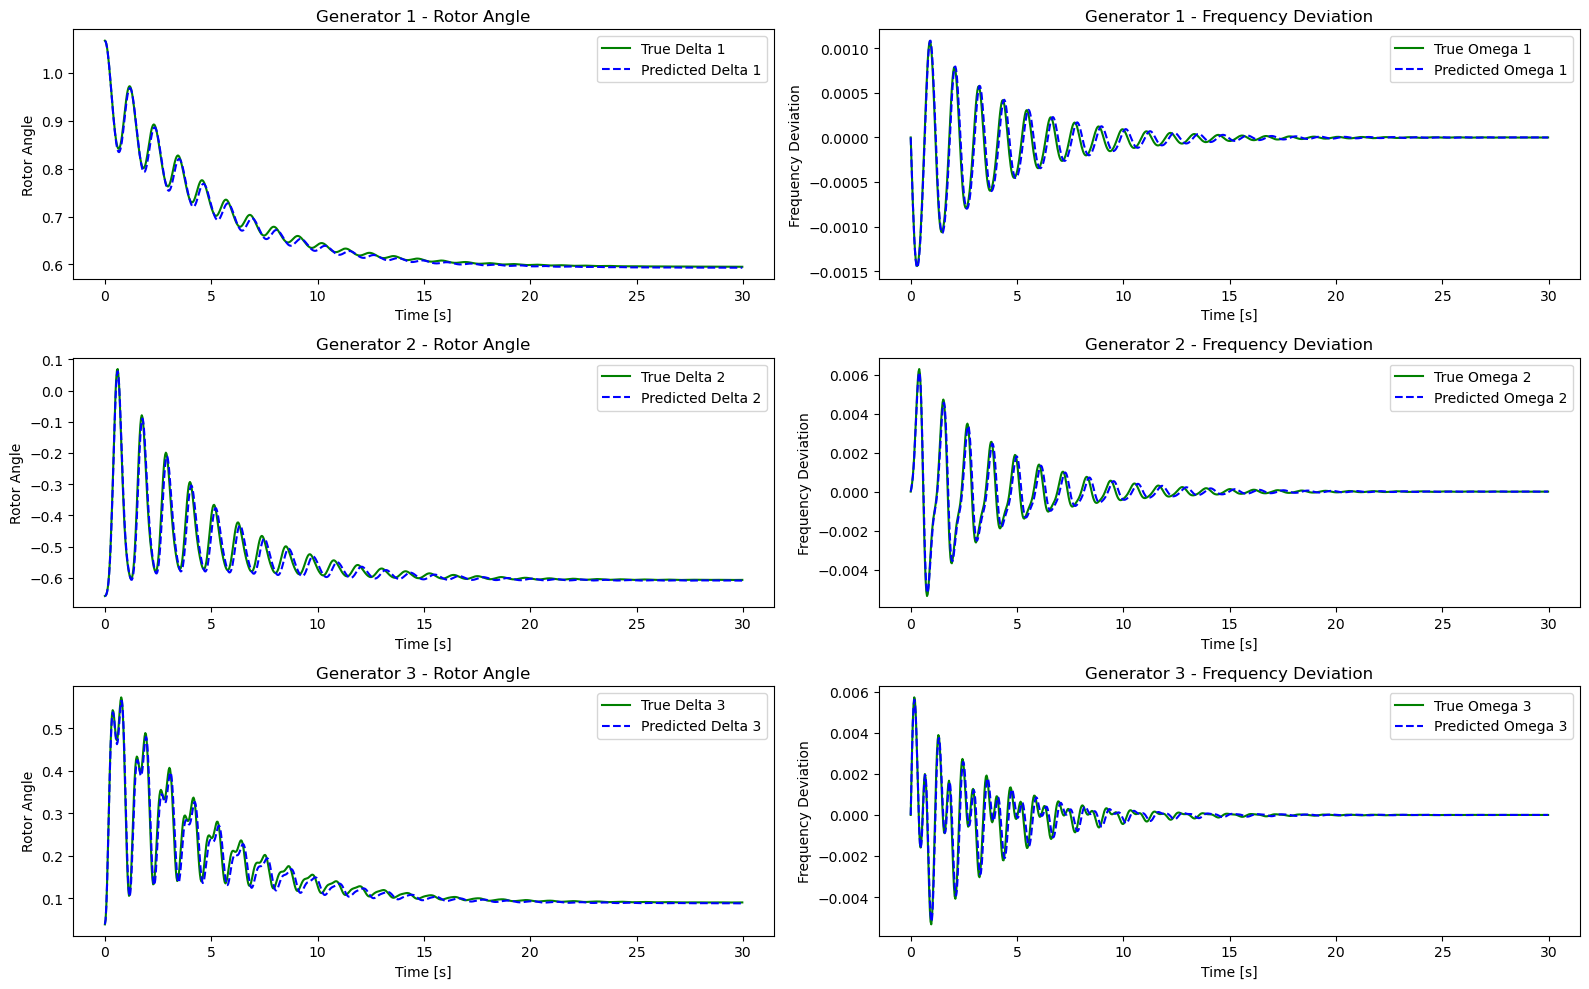

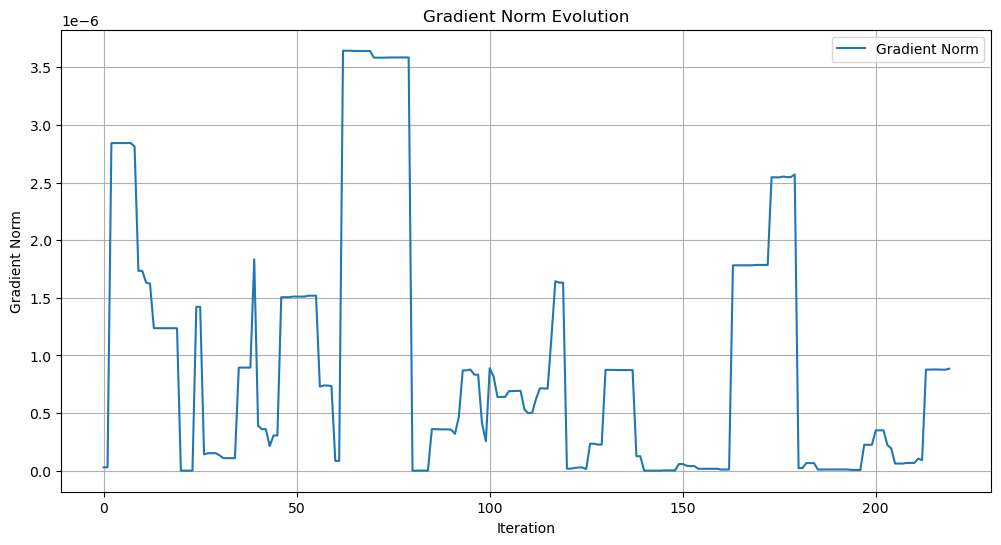


Iteration 20 | Total Loss 0.00007842807099223137
Updated Parameters:
M2: 18.402441024780273
M3: 12.177817344665527
D2: 10.284804344177246
D3: 10.273944854736328


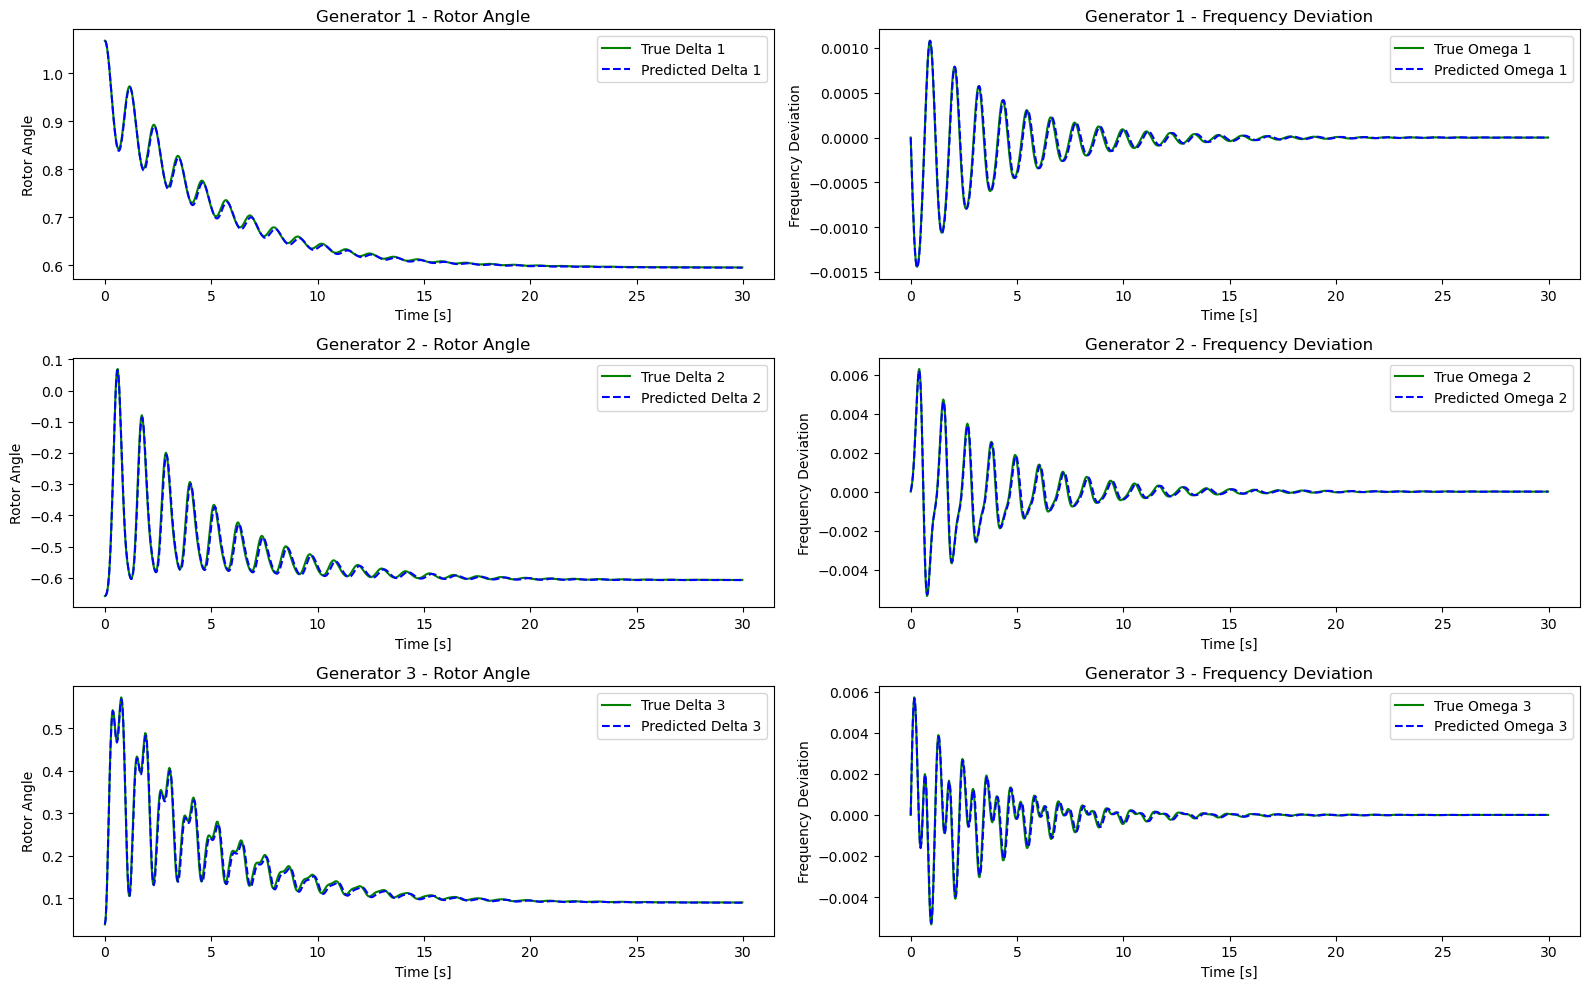

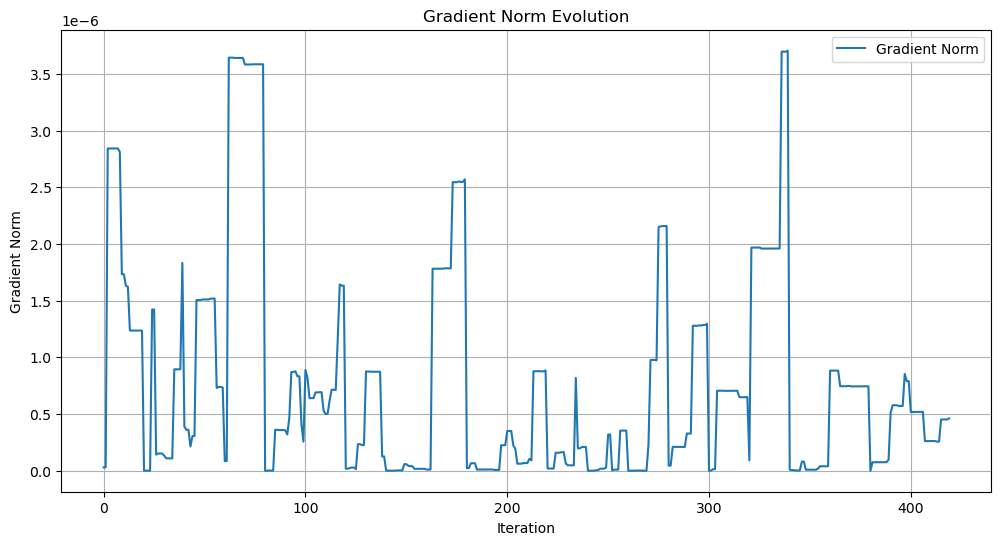


Iteration 30 | Total Loss 0.00000513338136443053
Updated Parameters:
M2: 18.111515045166016
M3: 12.004691123962402
D2: 10.103690147399902
D3: 10.10279369354248


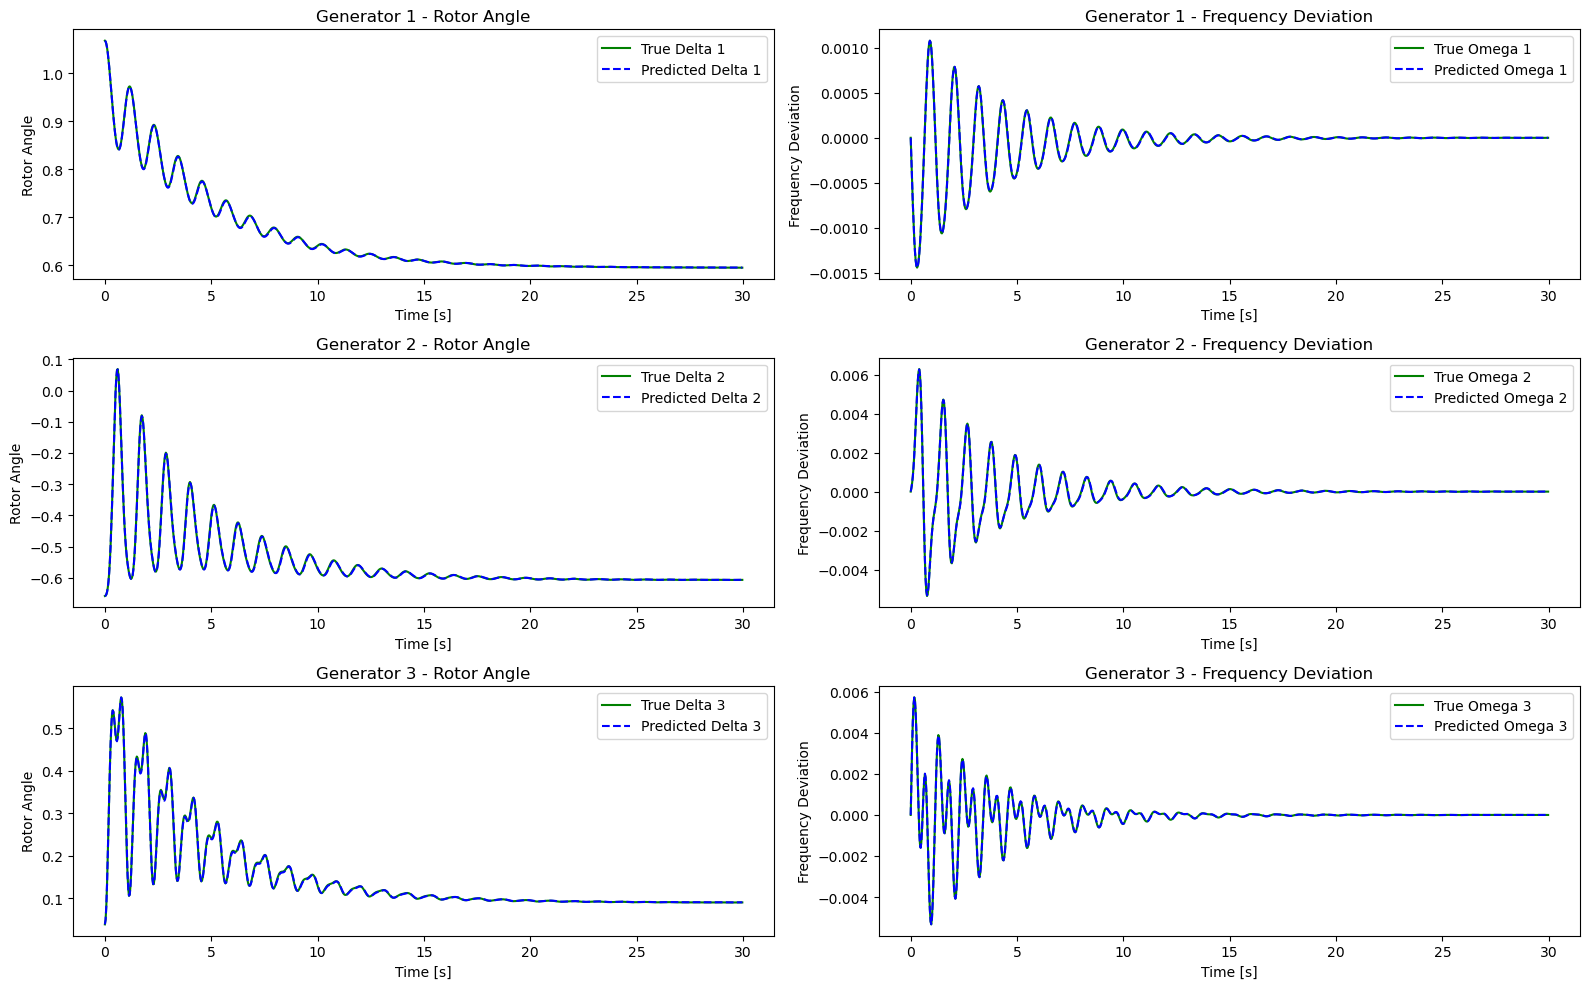

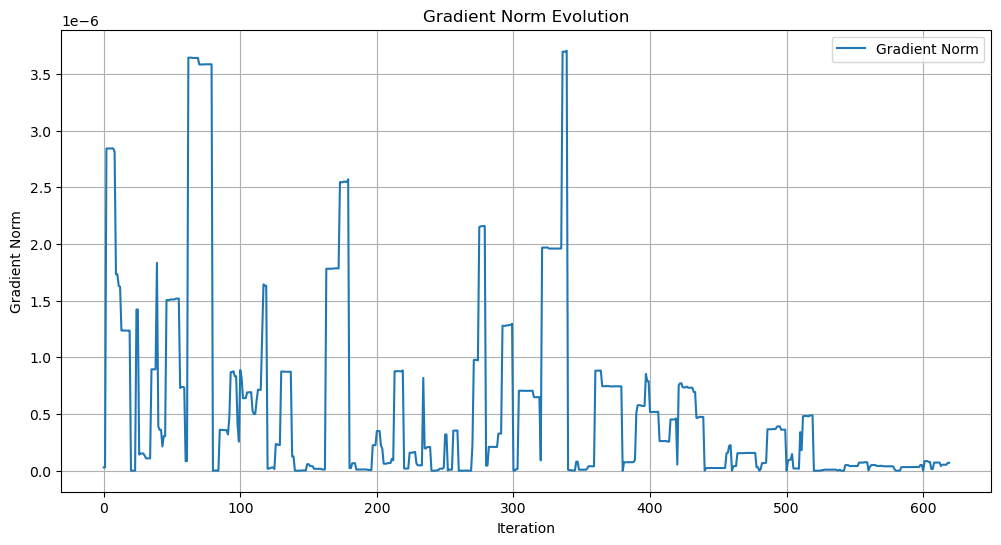


Iteration 40 | Total Loss 0.00000008592649436423
Updated Parameters:
M2: 18.013797760009766
M3: 12.001852035522461
D2: 9.997001647949219
D3: 10.027156829833984


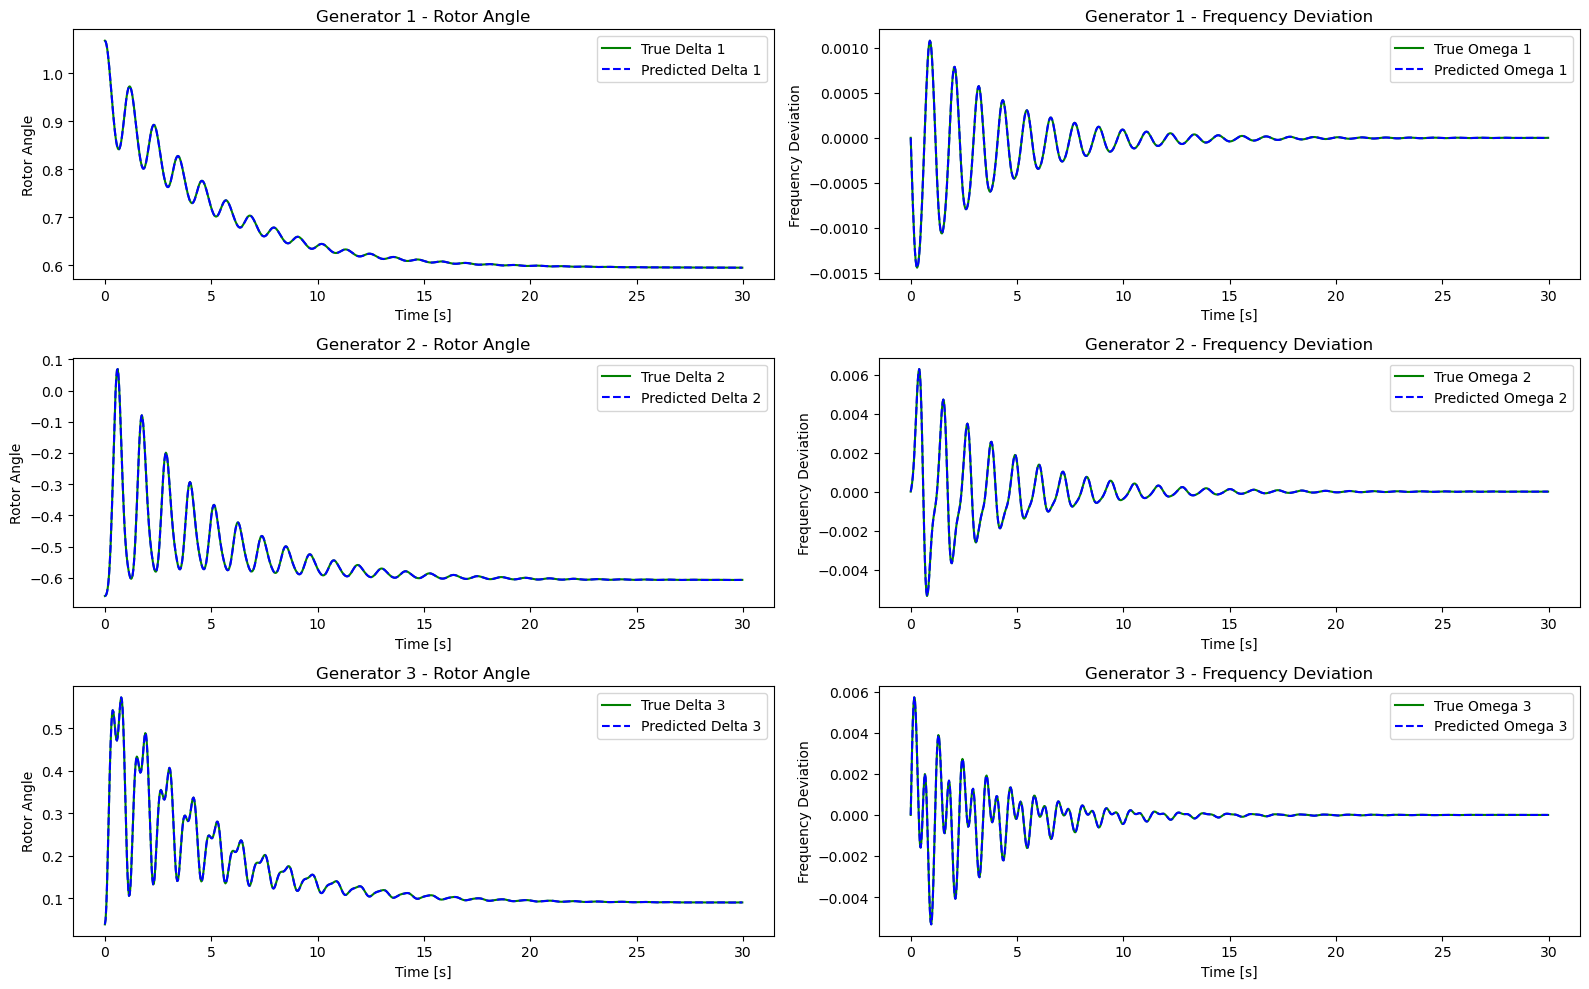

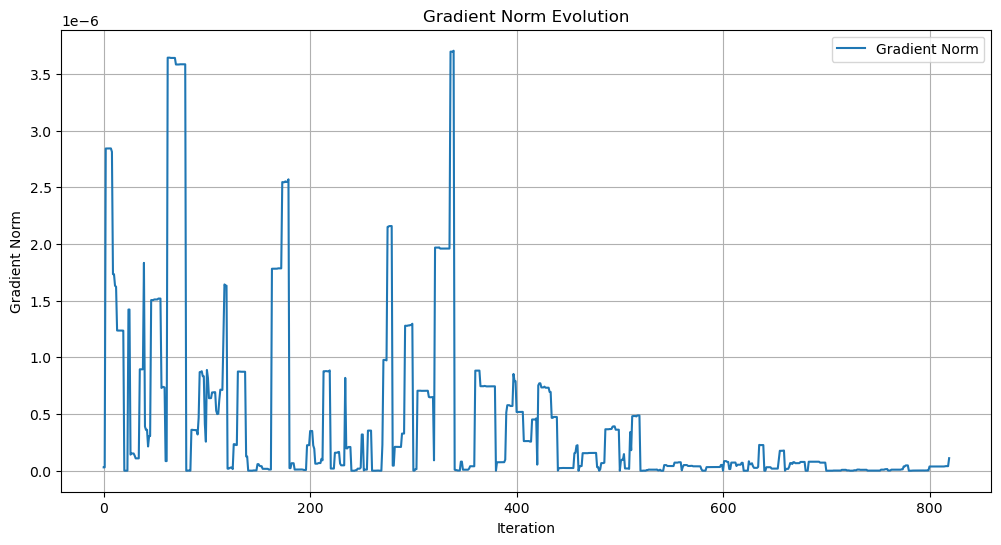


Iteration 50 | Total Loss 0.00000048522582574151
Updated Parameters:
M2: 17.958354949951172
M3: 12.071501731872559
D2: 10.071992874145508
D3: 10.072637557983398


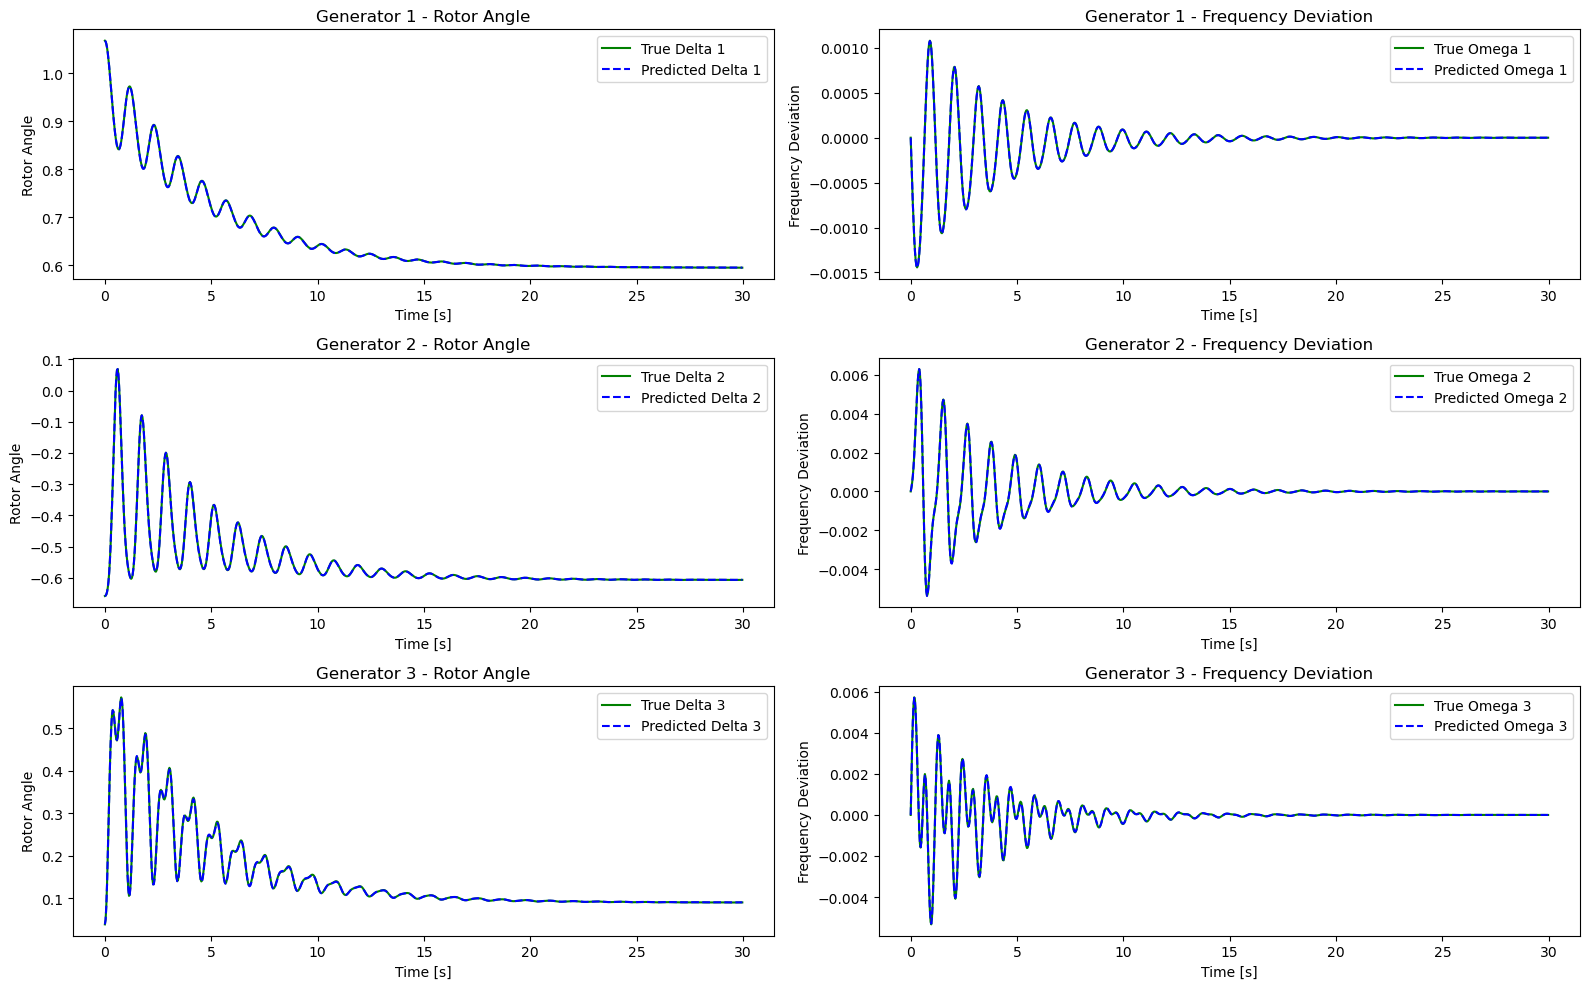

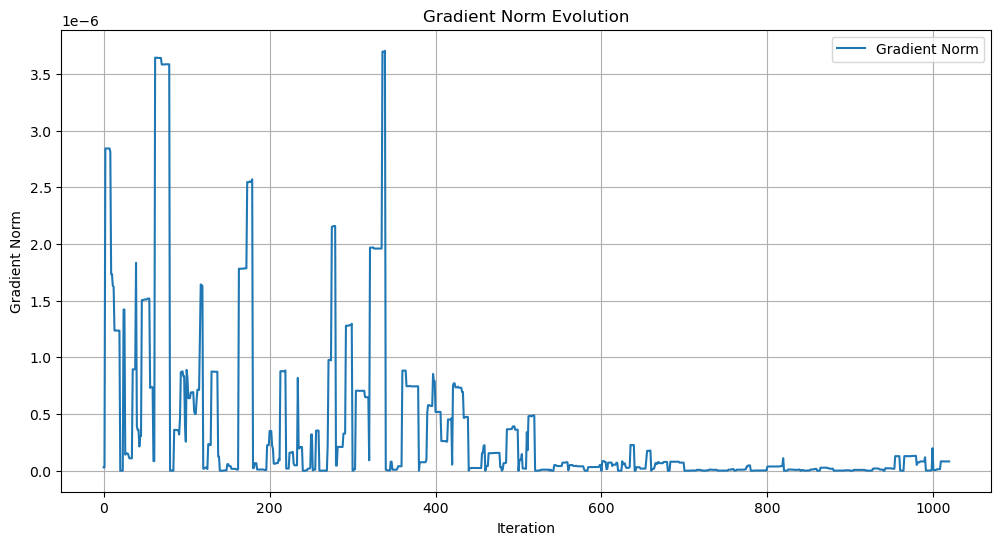


Iteration 60 | Total Loss 0.00000355958991349326
Updated Parameters:
M2: 17.930557250976562
M3: 11.937935829162598
D2: 10.05387020111084
D3: 9.983502388000488


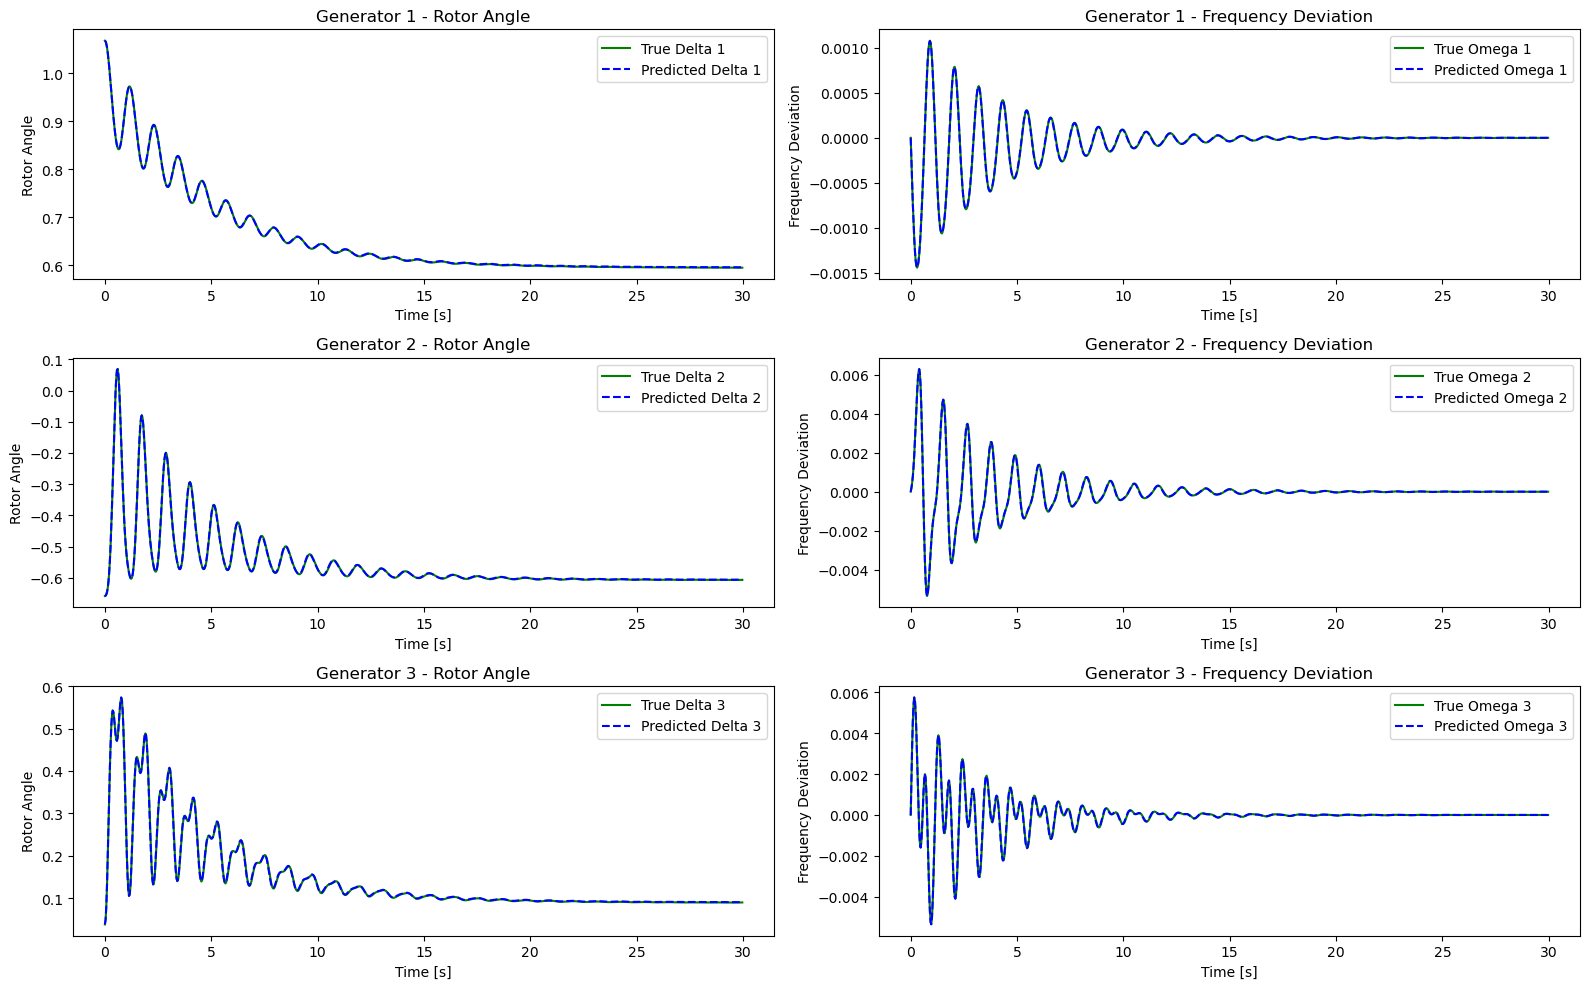

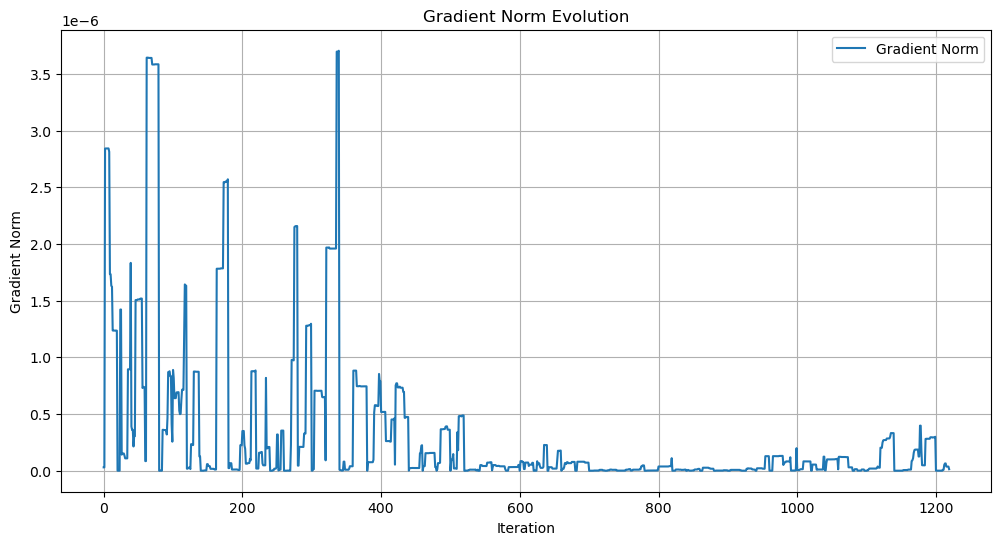

Stopping at iteration 68 as the norm of the gradients is below the threshold: 1e-15
Loss: 0.00000000000000004287
M2_G: 18.00020599365234375000
D2_G: 9.89010715484619140625
M3_G: 12.00133895874023437500
D3_G: 10.01879787445068359375
V2_G: 2.41783881187438964844
V3_G: 2.05036616325378417969
B12_G: -0.31089442968368530273
B13_G: -0.37298414111137390137
B23_G: -0.42915892601013183594
G12_G: 0.00059569207951426506
G13_G: -0.00763907097280025482
G23_G: -0.00469363899901509285
Pmech2_G: -3.02395629882812500000
Pmech3_G: 0.44815325736999511719

Iteration 68 | Total Loss 0.00000021271682726365
Updated Parameters:
M2: 18.000205993652344
M3: 12.001338958740234
D2: 9.890107154846191
D3: 10.018797874450684


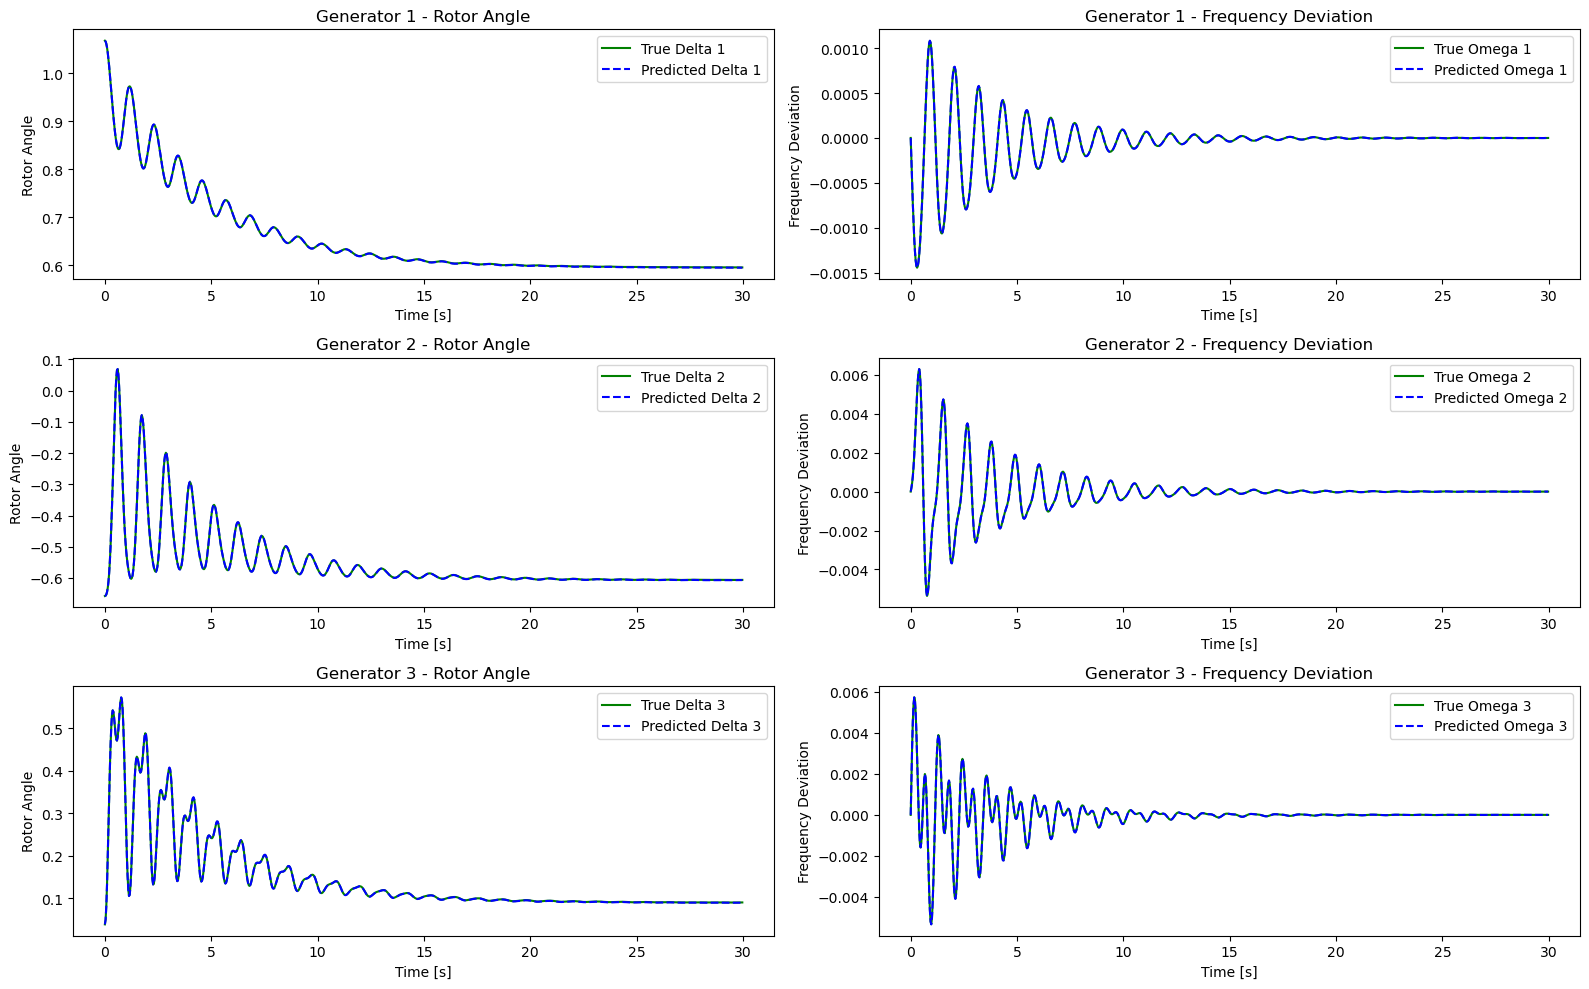

In [21]:
#Training loop - PC - MD
Delta = 1.10 #Porcentual deviation from real value
#TargetPercent = 0.01
Treshold = 1e-15 #2Bus2Gen: Originally 1e-13, 1e-11 for all cases, 1e-13 for M2, D2
M1_G = M1
D1_G = D1
M2_G = Delta*M2
D2_G = Delta*D2
M3_G = Delta*M3
D3_G = Delta*D3
V1_G = v1star
V2_G = v2star
V3_G = v3star
B12_G = B12
B13_G = B13
B23_G = B23
G12_G = G12
G13_G = G13
G23_G = G23
Pmech1_G = Pmech1star
Pmech2_G = Pmech2star
Pmech3_G = Pmech3star

parameters_correct = [M1,D1,M2,D2,M3,D3,v1star,v2star,v3star,B12,B13,B23,G12,G13,G23,Pmech1star,Pmech2star,Pmech3star]
parameters_data = []


csv_file_path = "C:/Users/LEGION/Documents/GitHub/torchdiffeq/3Bus3Gen/MD/Data_Win.csv"
plot_save_path = "C:/Users/LEGION/Documents/GitHub/torchdiffeq/3Bus3Gen/MD/Initial_Win.png"

os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)


#def percent_deviation(current_value, target_value):
#     return abs(current_value - target_value) / target_value * 100 #Relative Estimation Error

print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"M3: {M3.item()}", f"M3_G: {M3_G.item()}")
print(f"D3: {D3.item()}", f"D3_G: {D3_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"V3: {v3star.item()}", f"V3_G: {V3_G.item()}")
print(f"B12: {B12.item()}", f"B12_G: {B12_G.item()}")
print(f"B13: {B13.item()}", f"B13_G: {B13_G.item()}")
print(f"B23: {B23.item()}", f"B23_G: {B23_G.item()}")
print(f"G12: {G12.item()}", f"G12_G: {G12_G.item()}")
print(f"G13: {G13.item()}", f"G13_G: {G13_G.item()}")
print(f"G23: {G23.item()}", f"G23_G: {G23_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")
print(f"Pmech3: {Pmech3star.item()}", f"Pmech3_G: {Pmech3_G.item()}")

func = NeuralODE(M1_G, D1_G, M2_G, D2_G, M3_G, D3_G, V1_G, V2_G, V3_G, B12_G, B13_G, B23_G, G12_G, G13_G, G23_G, Pmech1_G, Pmech2_G, Pmech3_G).to(device)
normal_lr = 0.005
special_lr = 0.0005
special_param = [func.Pmech2, func.Pmech3]
other_param = [param for name, param in func.named_parameters() if param not in special_param]
param_groups = [{'params': other_param, 'lr': normal_lr}, {'params': special_param, 'lr': special_lr}]
optimizer = torch.optim.RMSprop(param_groups) #RMSprop
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.5, verbose=False)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, epochs=1000, steps_per_epoch=20)
end = time.time()
#time_meter = RunningAverageMeter(0.97)
#loss_meter = RunningAverageMeter(0.97)
ii = 0

with torch.no_grad():
    print('Initial Parameters:')
    for name, param in func.named_parameters():
        print(f"{name}: {param.data}")
    initial_pred = odeint(func,x0,t).to(device)
    initial_true = true_x.to(device)
    visualize(initial_true, initial_pred, t, omega0, viz, plot_save_path)

grad_norm_values = []
start_time = time.time()

for itr in range(0, niters):
    grad_norm = 0
    optimizer.zero_grad()
    s, batch_x0, batch_t, batch_x = get_batch()

    for batch_n in range(0,batch_size):
        low = int(s[batch_n])
        high = low + batch_time
        pred_x = odeint(func, batch_x0[batch_n], batch_t, method = method).to(device)
        #print(batch_n+1)
        #loss = torch.mean((pred_x - batch_x[:,batch_n,:,:])**2) #loss using all states.
        loss = torch.mean((pred_x[:,0:2,0] - batch_x[:,batch_n,0:2,0])**2) #loss using only delta1 and omega1.
        loss.backward() #Calculate the dloss/dparameters
        optimizer.step() #Update value of parameters

        with torch.no_grad():
            for name, param in func.named_parameters():
                if name in ['M2', 'D2', 'M3', 'D3']:
                    param.clamp_(min=0.1)
                
        for param in func.parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()**2
        grad_norm = math.sqrt(grad_norm)
        grad_norm_values.append(grad_norm)

        current_parameters = [param.item() for name, param in func.named_parameters()]
        iteration_time = time.time() - start_time
        parameters_data.append([itr] + current_parameters + [loss.item(), iteration_time, grad_norm])

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_x = odeint(func, x0, t).to(device)
            #loss = torch.mean((func.dydt -  real_dynamics.dxdt)**2)
            #loss = torch.mean((pred_x - true_x)**2) #Loss using all states.
            loss = torch.mean((pred_x[:,0:2,0] - true_x[:,0:2,0])**2) #Loss using only delta1 and omega1.
            print(f'\nIteration {itr:d} | Total Loss {loss.item():.20f}')
            print('Updated Parameters:')
            for name, param in func.named_parameters():
                print(f"{name}: {param.data}")
            plot_save_path = f'C:/Users/LEGION/Documents/GitHub/torchdiffeq/3Bus3Gen/MD/Iteration_{itr}_Win.png'
            visualize(true_x, pred_x, t, omega0, viz, plot_save_path)
            
            with open(csv_file_path, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                if itr == 0:
                    header = ['Iteration'] + [name for name, _ in func.named_parameters()] + ['Loss', 'Time', 'Gradient Norm']
                    writer.writerow(header)
                writer.writerows(parameters_data)
                parameters_data = []
            ii += 1

            plt.figure(figsize=(12, 6))
            plt.plot(grad_norm_values, label= 'Gradient Norm')
            plt.xlabel('Iteration')
            plt.ylabel('Gradient Norm')
            plt.title('Gradient Norm Evolution')
            plt.legend()
            plt.grid(True)
            plt.show()

    scheduler.step()
    end = time.time()

    #if grad_norm <= Treshold:
    if loss <= Treshold:
         print(f'Stopping at iteration {itr} as the norm of the gradients is below the threshold: {Treshold}')
         print(f'Loss: {loss.item():.20f}')
         print(f'M2_G: {func.M2.item():.20f}')
         print(f'D2_G: {func.D2.item():.20f}')
         print(f'M3_G: {func.M3.item():.20f}')
         print(f'D3_G: {func.D3.item():.20f}')
         print(f'V2_G: {func.V2.item():.20f}')
         print(f'V3_G: {func.V3.item():.20f}')
         print(f'B12_G: {func.B12.item():.20f}')
         print(f'B13_G: {func.B13.item():.20f}')
         print(f'B23_G: {func.B23.item():.20f}')
         print(f'G12_G: {func.G12.item():.20f}')
         print(f'G13_G: {func.G13.item():.20f}')
         print(f'G23_G: {func.G23.item():.20f}')
         print(f'Pmech2_G: {func.Pmech2.item():.20f}')
         print(f'Pmech3_G: {func.Pmech3.item():.20f}')

         with torch.no_grad():
             pred_x = odeint(func, x0, t).to(device)
             #loss = torch.mean((pred_x - true_x)**2) #Loss using all states.
             loss = torch.mean((pred_x[:,0:2,0] - true_x[:,0:2,0])**2) #Loss using only delta1 and omega1.
             print(f'\nIteration {itr:d} | Total Loss {loss.item():.20f}')
             print('Updated Parameters:')
             for name, param in func.named_parameters():
                 print(f"{name}: {param.data}")
             plot_save_path = f'C:/Users/LEGION/Documents/GitHub/torchdiffeq/3Bus3Gen/MD/Iteration_{itr}_Win.png'
             visualize(true_x, pred_x, t, omega0, viz, plot_save_path)
             with open(csv_file_path, 'a', newline='') as csvfile:
                 writer = csv.writer(csvfile)
                 writer.writerows(parameters_data)
         break
